# 09_LDA_Exploration
## Ray Hossain


## Setup

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
data = pd.read_csv("Processed_Data/80_TopicLDA_Long.csv")

In [12]:
#data.head()

In [13]:
data['left_right'] = data['left_right'].replace(-1,2)
data['left_right'].value_counts()

left_right
2    206533
1    187300
0     59022
Name: count, dtype: int64

## Shenanigans

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

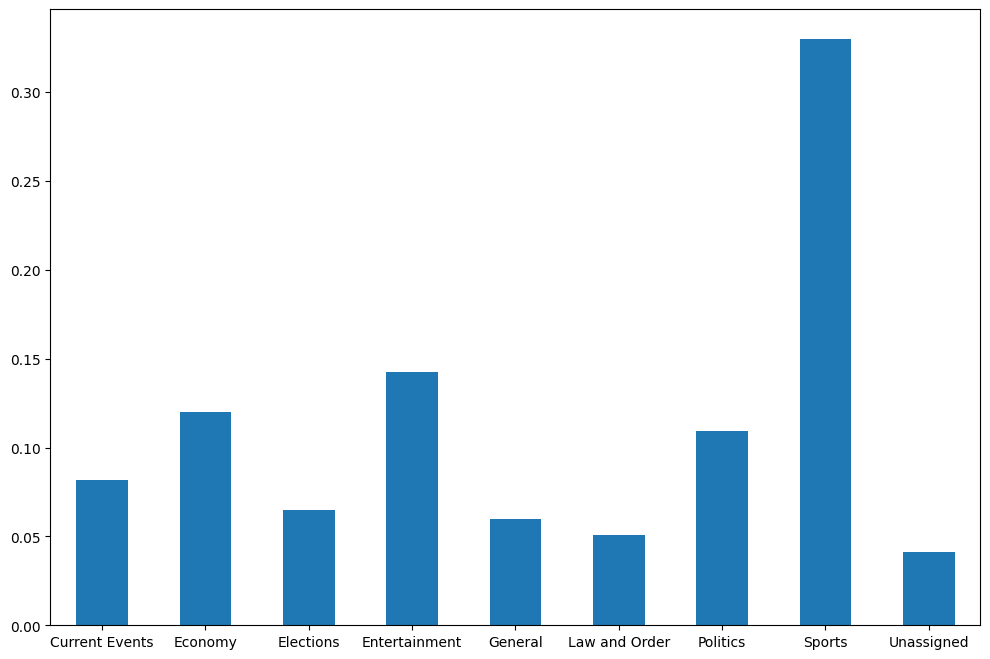

In [15]:
bins, counts = np.unique(data.topic_label, return_counts=True)
freq_series = pd.Series(counts/len(data.text_clean))
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

In [16]:
# Shuffle, then split the data into train and validation sets. Set the random_state 
# to 1 for reproducibility.
train_data, val_data, train_labels, val_labels = train_test_split(data.text_clean.astype(str), data.topic_label, train_size=0.8, random_state=42, stratify=data.topic_label) 
print('Training data size: {}'.format(len(train_data)))
print('Validation data size: {}'.format(len(val_data)))

Training data size: 362284
Validation data size: 90571


In [17]:
nlp = spacy.load('de_core_news_sm')
nlp.pipe_names
nlp = spacy.blank('de')

# There should be no pipeline components.
nlp.pipe_names
# For this exercise, we'll remove punctuation and spaces (which
# includes newlines), filter for tokens consisting of alphabetic
# characters only, and return the token text.
def spacy_tokenizer(doc):
  return [t.text for t in nlp(doc) if \
          not t.is_punct and \
          not t.is_space and \
          t.is_alpha]

In [18]:
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [19]:
# Instantiate a classifier with the default settings.
nb_classifier = MultinomialNB()
nb_classifier.fit(train_feature_vects, train_labels)
nb_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

In [20]:
# Get predictions on training set and calculate F1 score.
# See documentation above for more details on what "macro" means.
train_preds = nb_classifier.predict(train_feature_vects)
print('F1 score on initial training set: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

F1 score on initial training set: 0.8454209498885831


In [21]:
val_feature_vects = vectorizer.transform(val_data)

In [22]:
# Predict and evaluate.
val_preds = nb_classifier.predict(val_feature_vects)
print('F1 score on validation set: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

F1 score on validation set: 0.8133873232627901


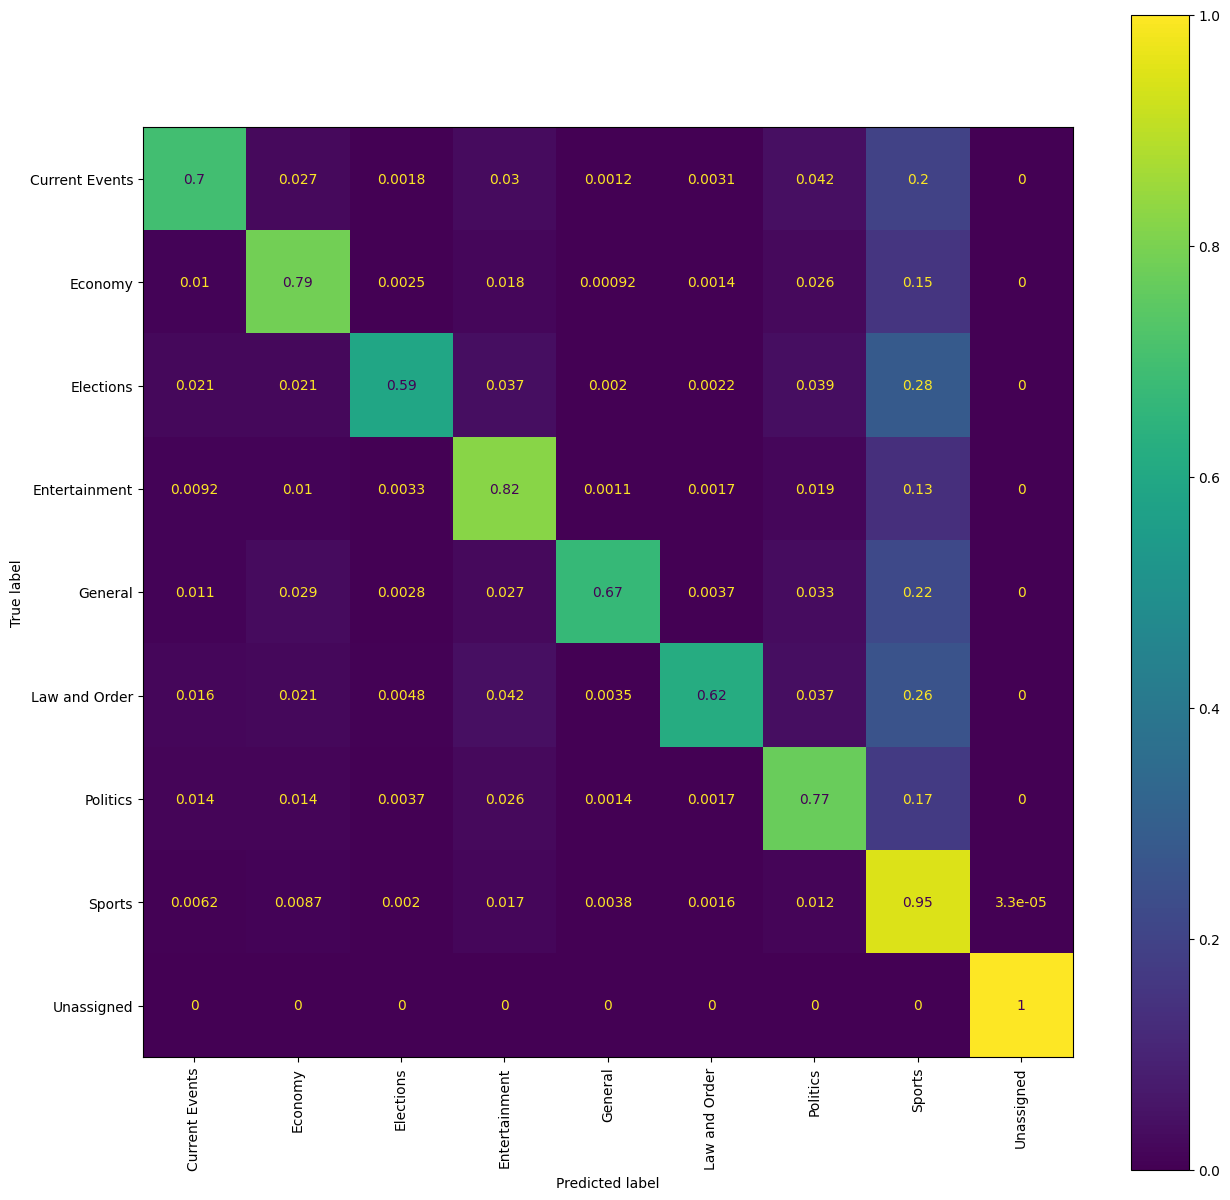

In [23]:
# Set the size of the plot.
fig, ax = plt.subplots(figsize=(15, 15))

# Create the confusion matrix. 
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=np.unique(data.topic_label), xticks_rotation='vertical', ax=ax)

In [24]:
target_names = sorted(data.topic_label.unique())

print(metrics.classification_report(val_labels, val_preds, target_names=target_names))


                precision    recall  f1-score   support

Current Events       0.86      0.70      0.77      7415
       Economy       0.88      0.79      0.83     10857
     Elections       0.94      0.59      0.73      5868
 Entertainment       0.86      0.82      0.84     12929
       General       0.95      0.67      0.79      5404
 Law and Order       0.95      0.62      0.75      4590
      Politics       0.81      0.77      0.79      9899
        Sports       0.73      0.95      0.82     29894
    Unassigned       1.00      1.00      1.00      3715

      accuracy                           0.82     90571
     macro avg       0.89      0.77      0.81     90571
  weighted avg       0.84      0.82      0.81     90571



## Voting Behaviour from Topics


In [25]:
# Simplified mapping: just number to name
party_label = {
    1: 'Left',
    2: 'Right',
    0: 'Center',
}

# Map the party names to a new column
data['partylabel'] = data['left_right'].map(party_label)


In [26]:
# Step 1: Split raw text (not yet vectorized)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    data.topic_label,
    data.partylabel,
    train_size=0.8,
    random_state=42,
    stratify=data.partylabel
)

print('Training data size: {}'.format(len(X_train_raw)))
print('Validation data size: {}'.format(len(X_val_raw)))

Training data size: 362284
Validation data size: 90571


In [27]:
from sklearn.feature_extraction.text import CountVectorizer


In [28]:
# Step 2: Vectorize the topic labels (i.e., your features)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_val = vectorizer.transform(X_val_raw)

# Step 3: Train the model
nb_classifier2 = MultinomialNB()
nb_classifier2.fit(X_train, y_train)

MultinomialNB()

In [29]:
nb_classifier2.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

In [30]:
# Get predictions on training set and calculate F1 score (macro avg)
train_preds2 = nb_classifier2.predict(X_train)
print('F1 score on training set: {:.4f}'.format(metrics.f1_score(y_train, train_preds2, average='macro')))


F1 score on training set: 0.3253


In [31]:
# Predict and evaluate.
val_preds2 = nb_classifier2.predict(X_val)
print('F1 score on validation set: {:.4f}'.format(metrics.f1_score(y_val, val_preds2, average='macro')))

F1 score on validation set: 0.3250


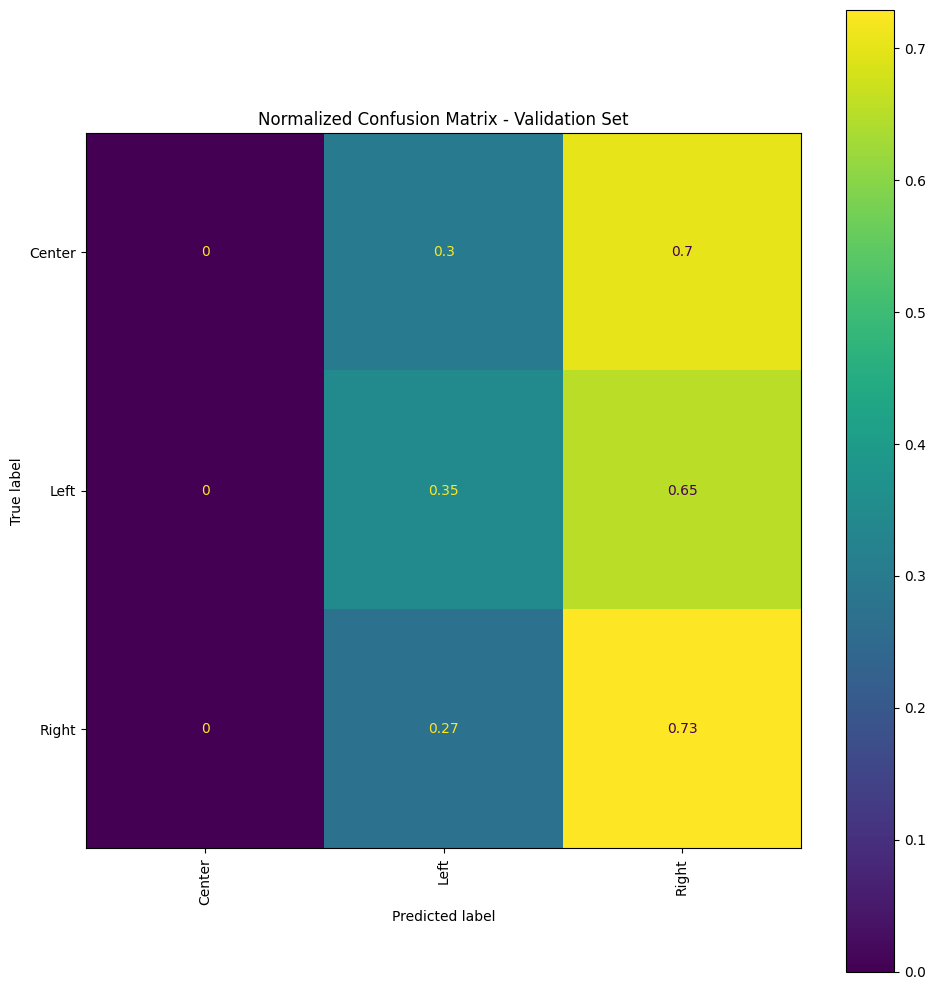

In [32]:
# Set the size of the plot.
fig, ax = plt.subplots(figsize=(10, 10))

# Create the confusion matrix.
ConfusionMatrixDisplay.from_estimator(
    nb_classifier2,
    X_val,
    y_val,
    normalize='true',
    display_labels=np.unique(y_val),
    xticks_rotation='vertical',
    ax=ax
)

plt.title("Normalized Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

In [33]:
print(data['partylabel'].value_counts())



partylabel
Right     206533
Left      187300
Center     59022
Name: count, dtype: int64


In [34]:
from sklearn.utils import resample

# Step 1: Group data by partylabel
grouped = data.groupby('partylabel')

# Step 2: Find the size of the smallest group
min_size = grouped.size().min()

# Step 3: Downsample all groups to min_size
balanced_data = grouped.apply(lambda x: resample(x, replace=False, n_samples=min_size, random_state=42))

# Step 4: Remove the multi-index caused by groupby + apply
balanced_data = balanced_data.droplevel(0).reset_index(drop=True)


C:\Users\rafid\AppData\Local\Temp\ipykernel_49928\3457917010.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = grouped.apply(lambda x: resample(x, replace=False, n_samples=min_size, random_state=42))


In [35]:
# Check counts per class
balanced_data['partylabel'].value_counts()


partylabel
Center    59022
Left      59022
Right     59022
Name: count, dtype: int64

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Step 5: Set X (features) and y (labels)
X = balanced_data['topic_label']  # Features (text data)
y = balanced_data['partylabel']   # Labels (party labels)

# Step 6: Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

# Step 7: Create a CountVectorizer and vectorize the training and validation data
vectorizer = CountVectorizer()

# Vectorize the training data (X_train)
X_train_vect = vectorizer.fit_transform(X_train)

# Vectorize the validation data (X_val)
X_val_vect = vectorizer.transform(X_val)


In [37]:

from sklearn.naive_bayes import MultinomialNB

# Step 8: Instantiate the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Step 9: Train the classifier on the training data
nb_classifier.fit(X_train_vect, y_train)


MultinomialNB()

F1 score on validation set: 0.3863985459348142


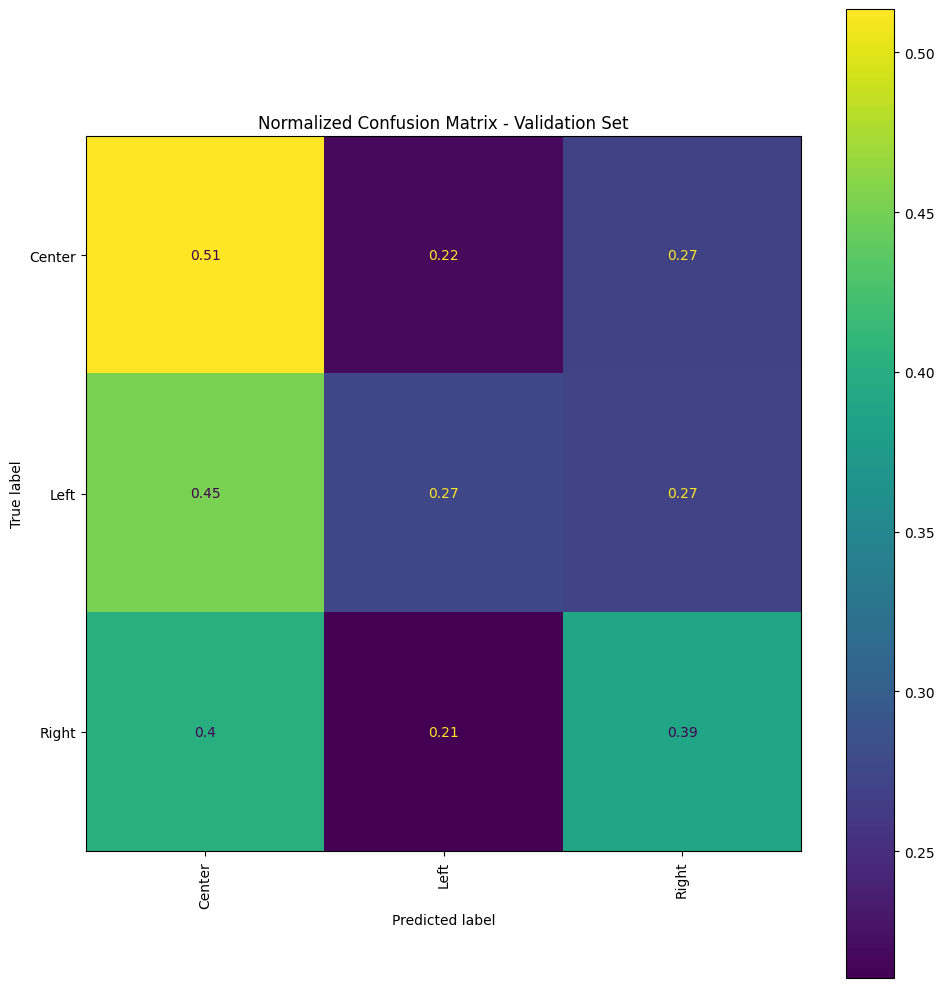

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# Step 10: Predict on the validation set
y_pred = nb_classifier.predict(X_val_vect)

# Step 11: Calculate and print the F1 score (macro average)
print(f'F1 score on validation set: {f1_score(y_val, y_pred, average="macro")}')

# Step 12: Plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))

# Create and plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    nb_classifier, 
    X_val_vect, 
    y_val, 
    normalize='true', 
    display_labels=nb_classifier.classes_,
    xticks_rotation='vertical',
    ax=ax
)

# Set the title and display the plot
plt.title("Normalized Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452855 entries, 0 to 452854
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   personid                    452855 non-null  int64  
 1   urlid                       452519 non-null  object 
 2   duration                    452519 non-null  float64
 3   text_clean                  434278 non-null  object 
 4   secondvote                  452855 non-null  int64  
 5   vote_left                   452855 non-null  int64  
 6   vote_green                  452855 non-null  int64  
 7   vote_spd                    452855 non-null  int64  
 8   vote_na_other               452855 non-null  int64  
 9   vote_fdp                    452855 non-null  int64  
 10  vote_cdu                    452855 non-null  int64  
 11  vote_afd                    452855 non-null  int64  
 12  news_proportion             452855 non-null  float64
 13  age           